In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random

from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
X_train = torch.load('/kaggle/input/pulsedb-dataset-pytorch-tensors/X_train.pt')
Y_train = torch.load('/kaggle/input/pulsedb-dataset-pytorch-tensors/Y_train.pt')
X_test = torch.load('/kaggle/input/pulsedb-dataset-pytorch-tensors/X_test.pt')
Y_test = torch.load('/kaggle/input/pulsedb-dataset-pytorch-tensors/Y_test.pt')

X_train[:, :1250] = 2 * X_train[:, :1250] - 1
X_test[:, :1250] = 2 * X_test[:, :1250] - 1

## Dataset

In [ ]:
batch_size = 12

In [ ]:
# Dataset and DataLoader
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## RNN 3 Ways

In [65]:
class RNNModelConcatenating(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_additional_features):
        super(RNNModelConcatenating, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size + num_additional_features, output_size)

    def forward(self, x, additional_features):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        
        # Repeat additional features for each time step
        additional_features_repeated = additional_features.unsqueeze(1).repeat(1, out.size(1), 1)
        
        # Concatenate RNN output with additional features
        combined = torch.cat((out, additional_features_repeated), dim=2)
        
        # Apply final fully connected layer
        out = self.fc(combined)
        return out

In [66]:
# # Hyperparameters
# input_size = 1
# hidden_size = 64
# output_size = 1
# num_layers = 2
# num_additional_features = 5

# # Model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = RNNModelConcatenating(input_size, hidden_size, output_size, num_layers, num_additional_features).to(device)

# # Multi-GPU support
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs")
#     model = nn.DataParallel(model)

In [70]:
class RNNModelHiddenState(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_additional_features):
        super(RNNModelHiddenState, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_init = nn.Linear(num_additional_features, hidden_size)

    def forward(self, x, additional_features):
        # Initialize hidden state using additional features
        h0 = self.hidden_init(additional_features).unsqueeze(0).repeat(self.num_layers, 1, 1)
        
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

In [72]:
# # Hyperparameters
# input_size = 1
# hidden_size = 64
# output_size = 1
# num_layers = 2
# num_additional_features = 5

# # Model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = RNNModelHiddenState(input_size, hidden_size, output_size, num_layers, num_additional_features).to(device)

# # Multi-GPU support
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs")
#     model = nn.DataParallel(model)

In [76]:
class RNNModelDualInput(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_additional_features):
        super(RNNModelDualInput, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_additional = nn.Sequential(
            nn.Linear(num_additional_features, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )
        self.fc_combined = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x, additional_features):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        rnn_out, _ = self.rnn(x, h0)
        additional_out = self.fc_additional(additional_features).unsqueeze(1).repeat(1, rnn_out.size(1), 1)
        
        combined = torch.cat((rnn_out, additional_out), dim=2)
        out = self.fc_combined(combined)
        return out

In [78]:
# Hyperparameters
input_size = 1
hidden_size = 64
output_size = 1
num_layers = 2
num_additional_features = 5

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNModelHiddenState(input_size, hidden_size, output_size, num_layers, num_additional_features).to(device)

# Multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

## Train

In [79]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [80]:
def plot_random_sample(model, X_test, Y_test, device, epoch, batch=None):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        random_idx = random.randint(0, len(X_test) - 1)  # Random sample index
        sample_input = X_test[random_idx, :1250].unsqueeze(0).unsqueeze(2).to(device)  # Shape [1, 1250, 1]
        sample_input_f = X_test[random_idx, 1250:].reshape(1, 5).to(device)
        sample_output = model(sample_input, sample_input_f)  # Get the model's prediction

        # Plot actual vs predicted ABP
        plt.figure(figsize=(10, 5))
        plt.plot(Y_test[random_idx].cpu().numpy(), label='Actual', color='red')
        plt.plot(sample_output.cpu().squeeze().detach().numpy(), label='Predicted', color='blue')
        if batch:
            plt.title(f'Epoch {epoch + 1} | Batch {batch+1}: Random Sample Prediction')
        else:
            plt.title(f'Epoch {epoch + 1}: Random Sample Prediction')
        plt.xlabel('Time')
        plt.ylabel('ABP')
        plt.legend()
        plt.show()
    model.train()

6954.01708984375


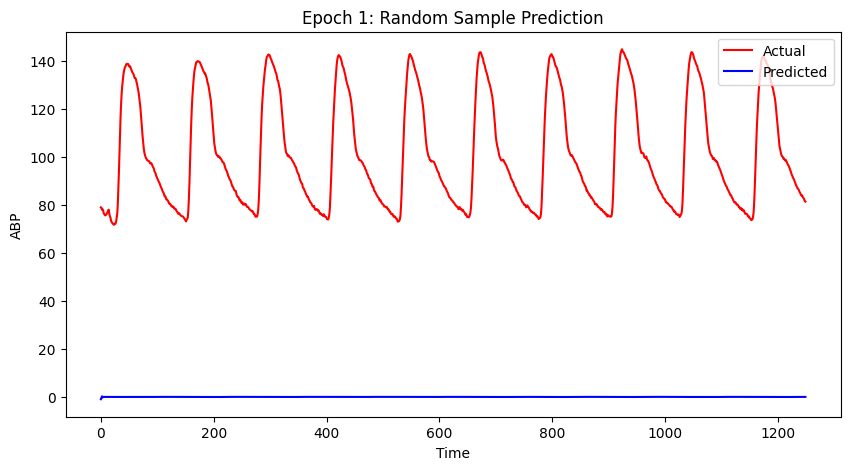

4097.44140625


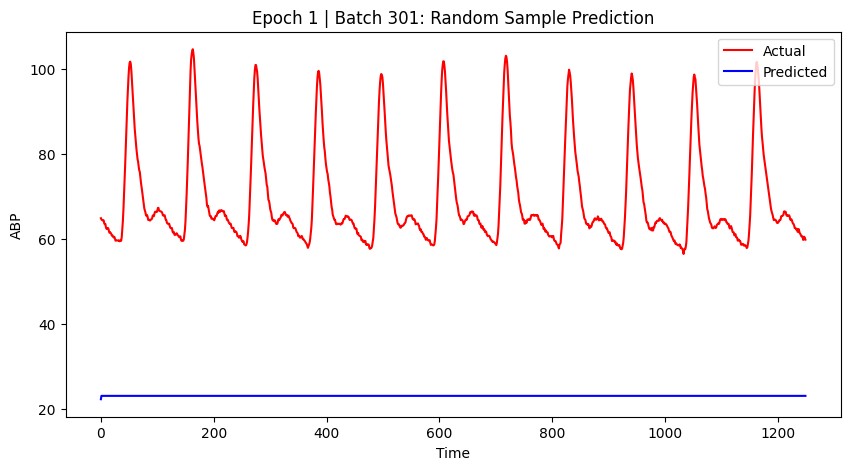

1993.96240234375


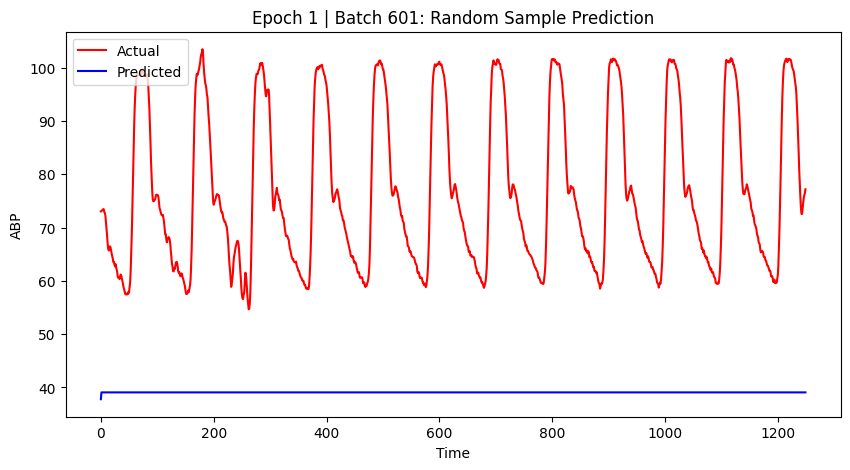

1065.503173828125


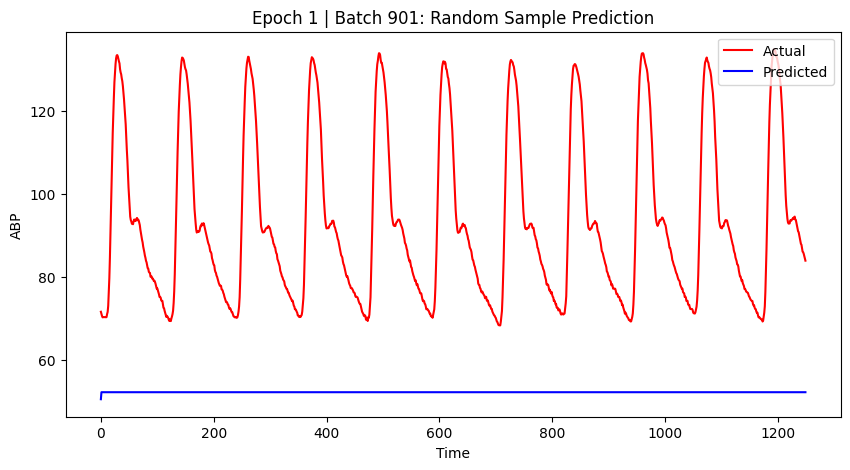

693.2175903320312


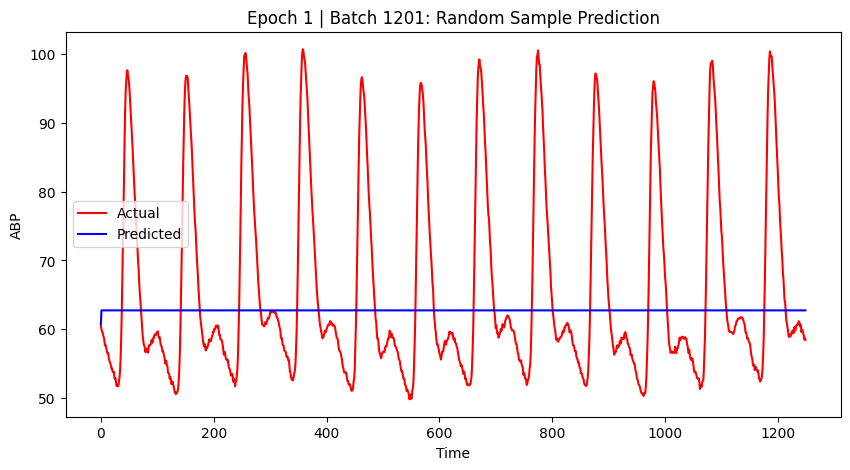

702.695068359375


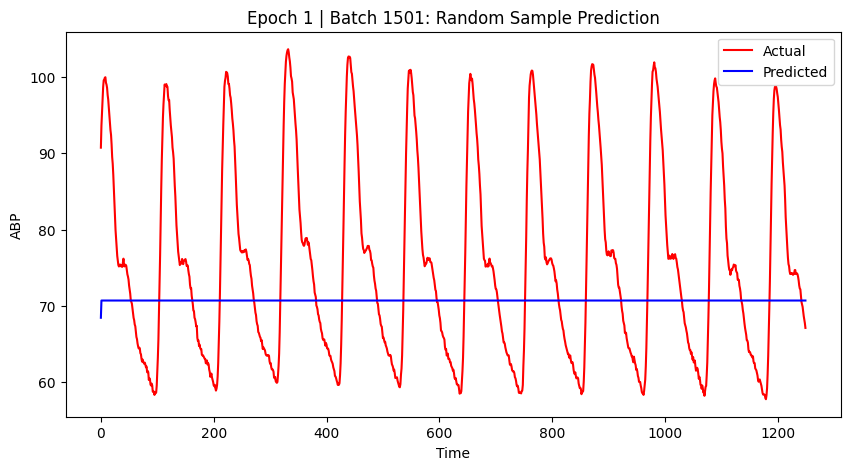

554.5772705078125


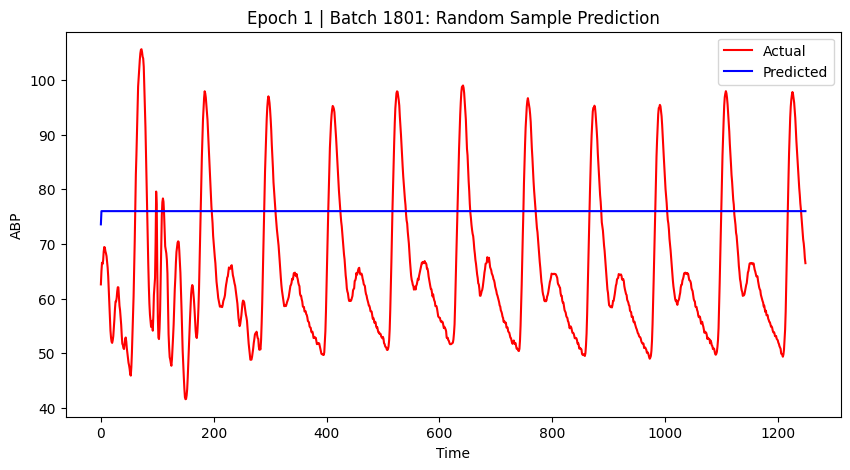

560.7794799804688


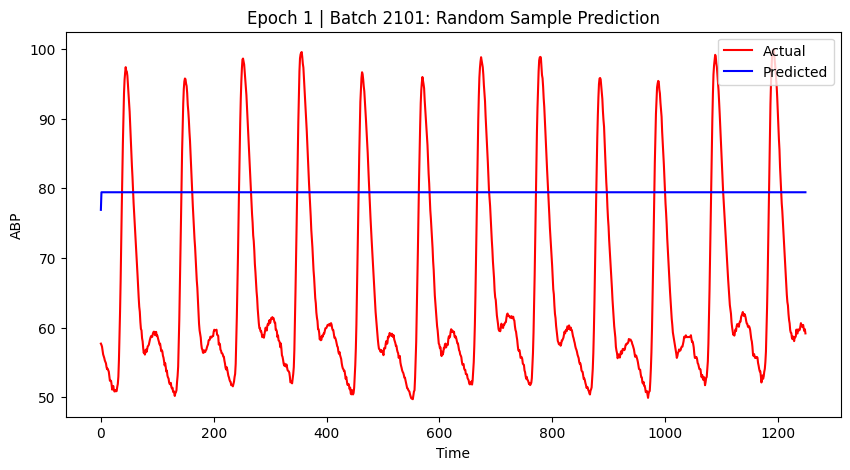

829.5678100585938


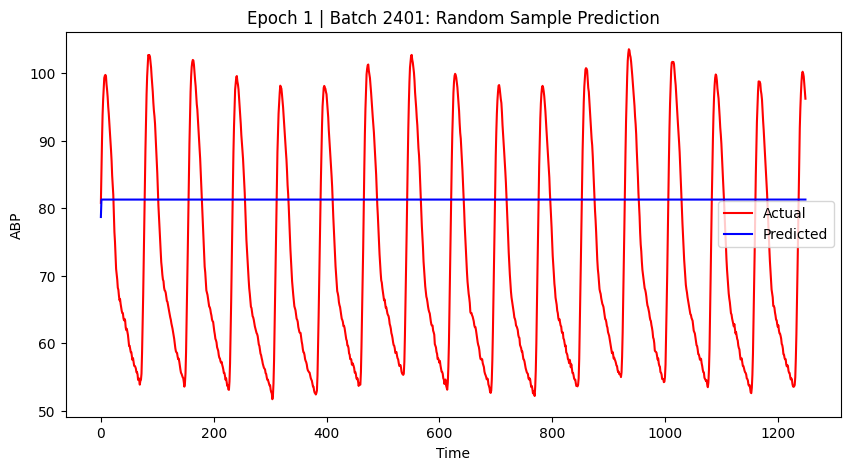

635.8240356445312


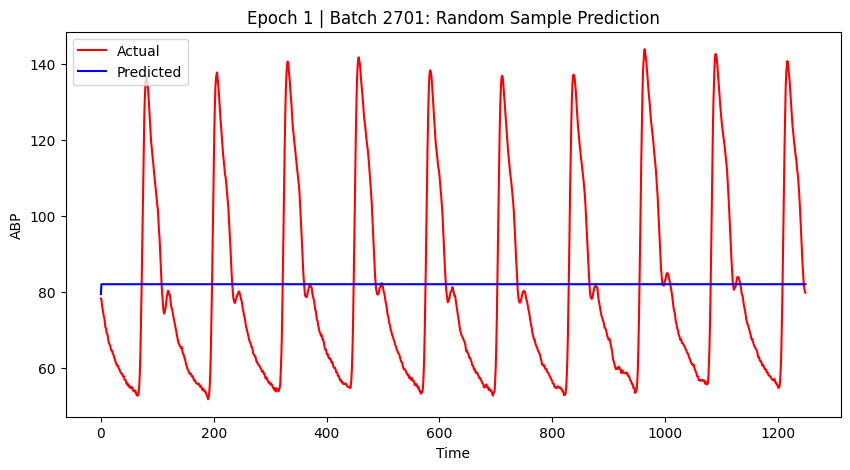

652.4708862304688


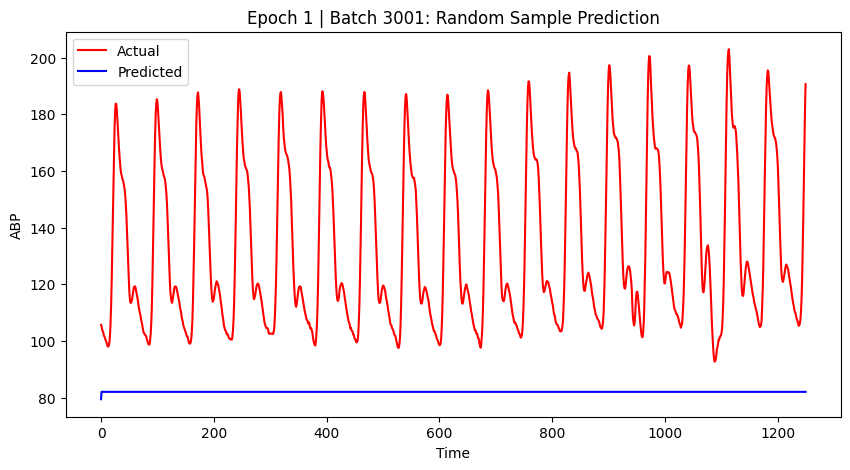

508.90106201171875


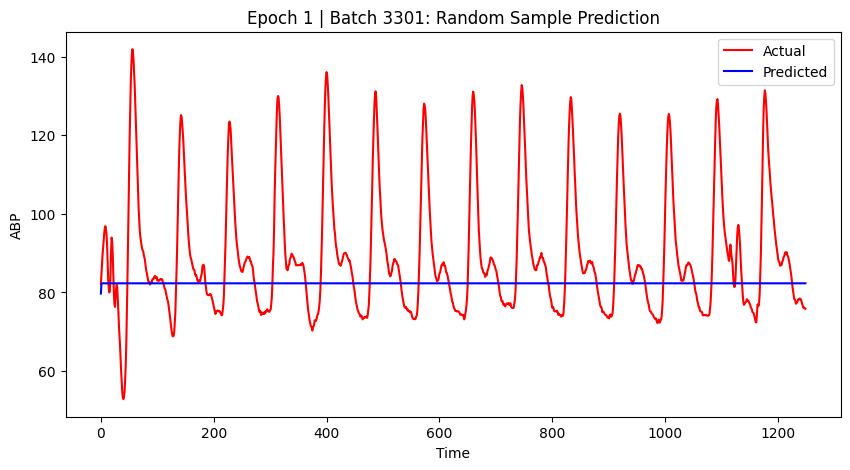

543.3782958984375


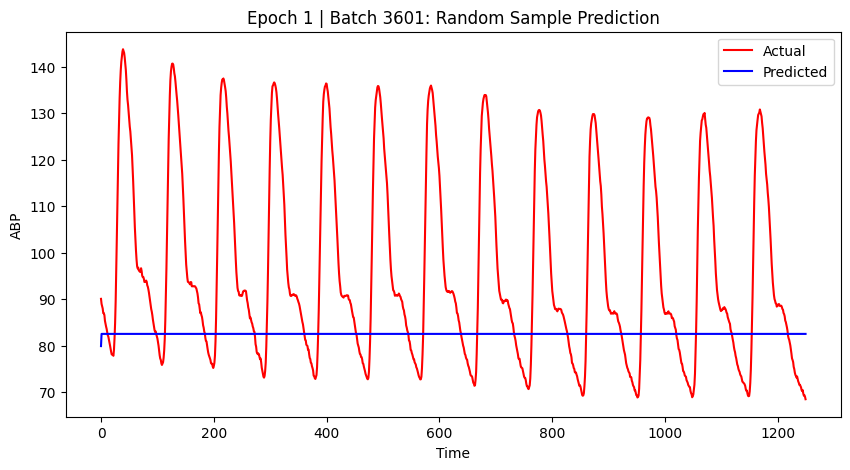

370.0303955078125


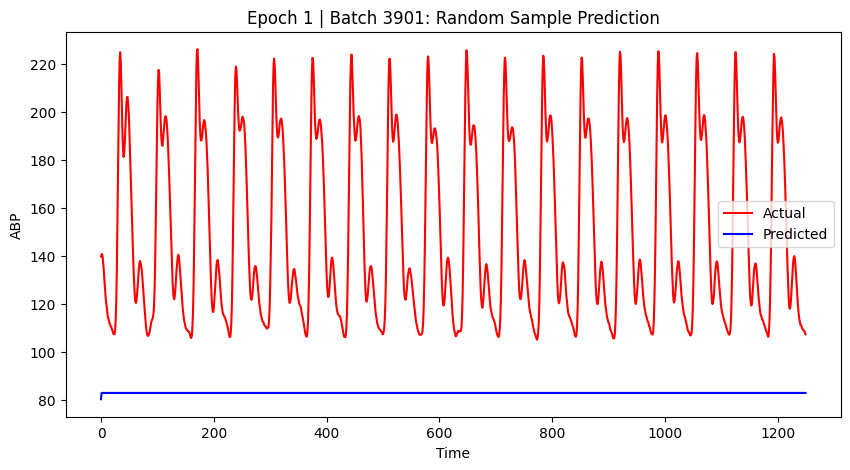

379.3848571777344


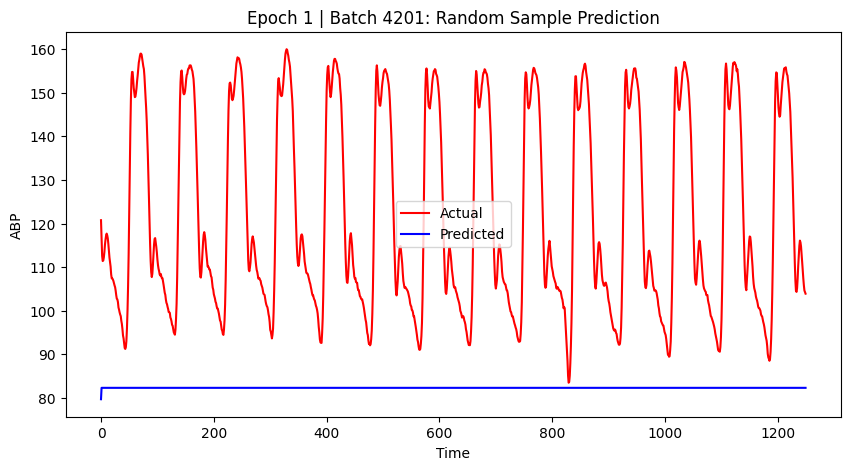

593.3733520507812


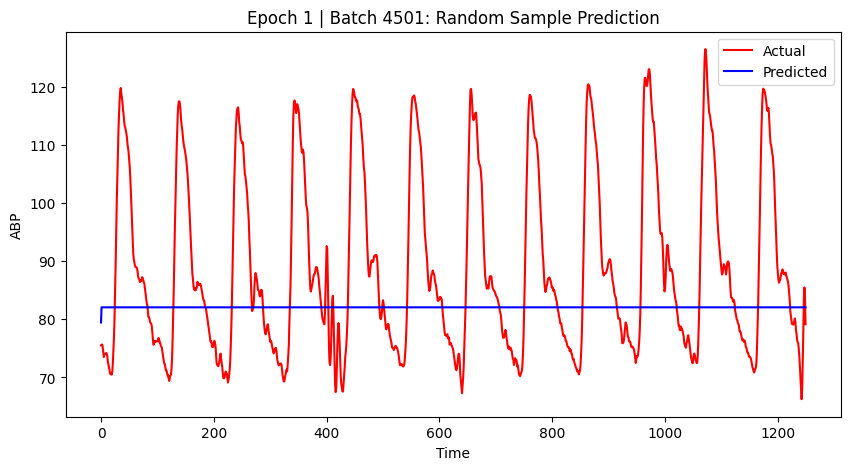

620.6818237304688


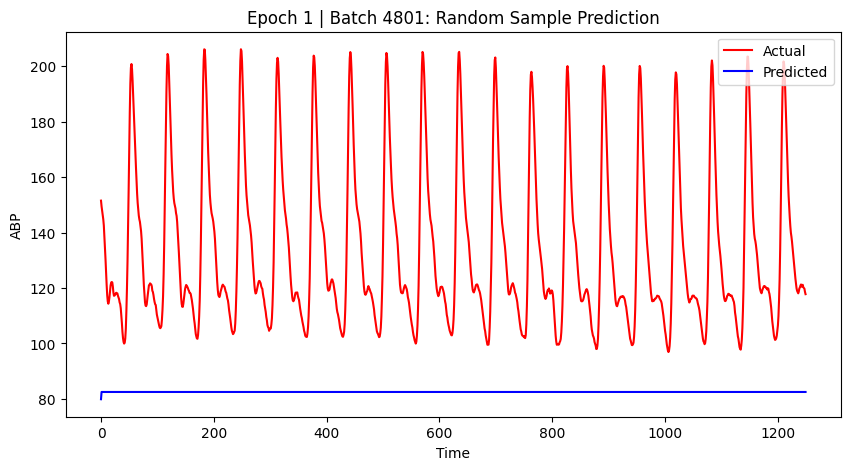

703.148681640625


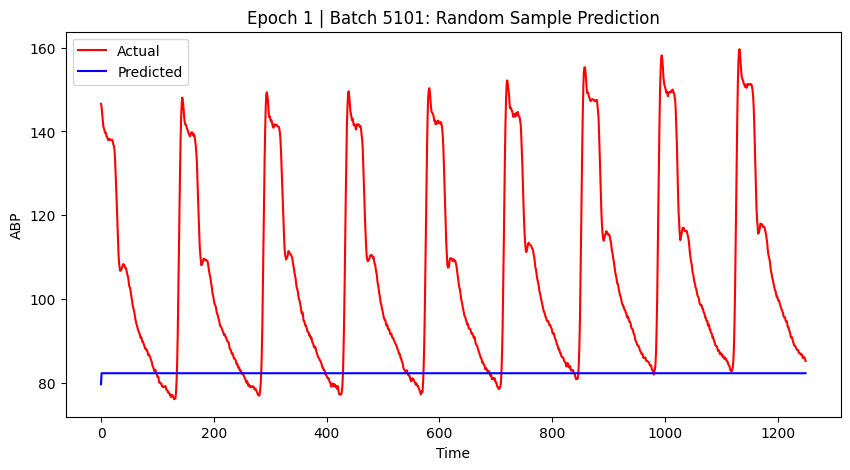

392.8872375488281


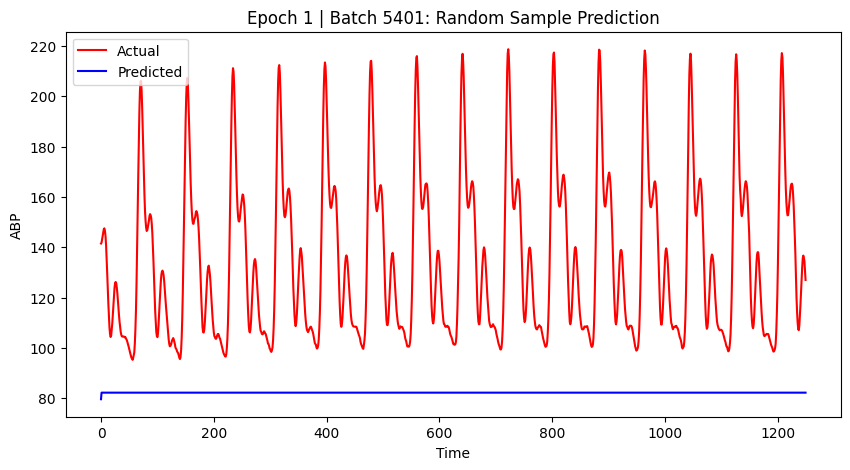

591.2239379882812


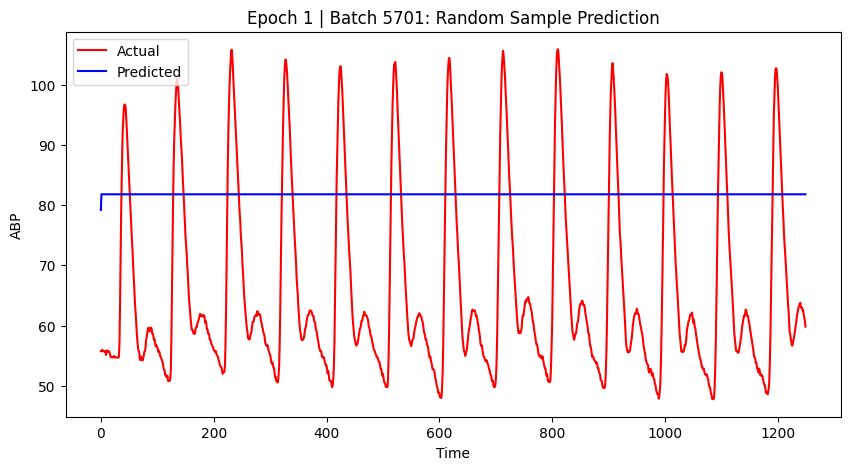

478.55218505859375


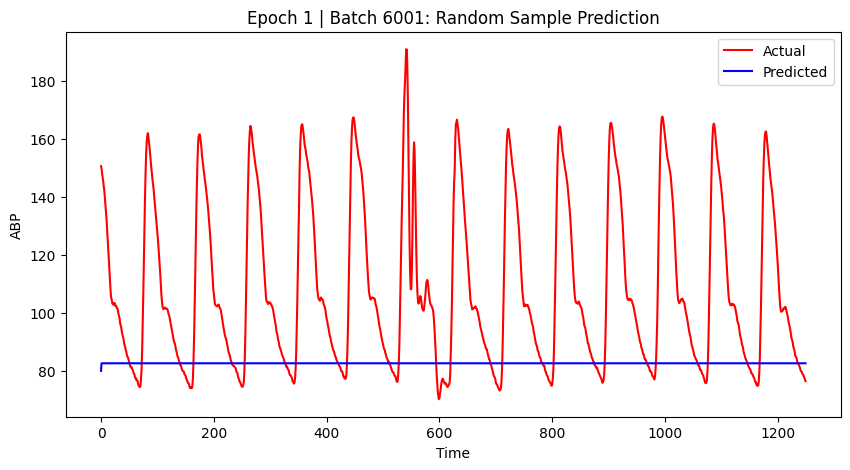

696.2262573242188


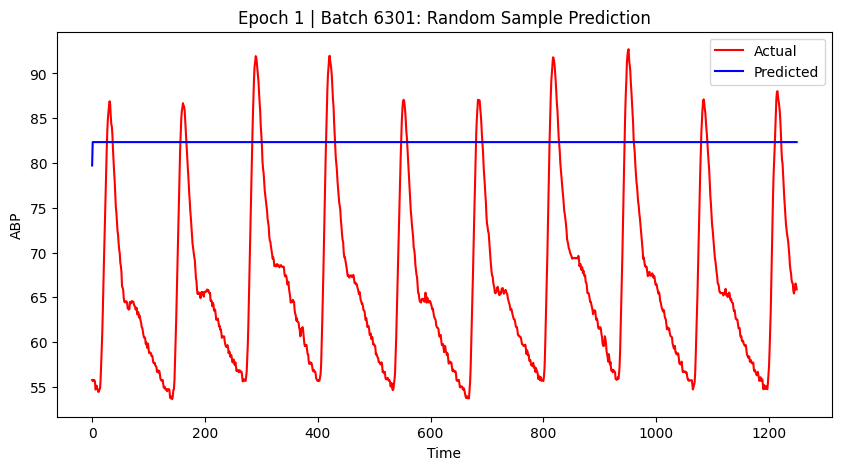

469.0370788574219


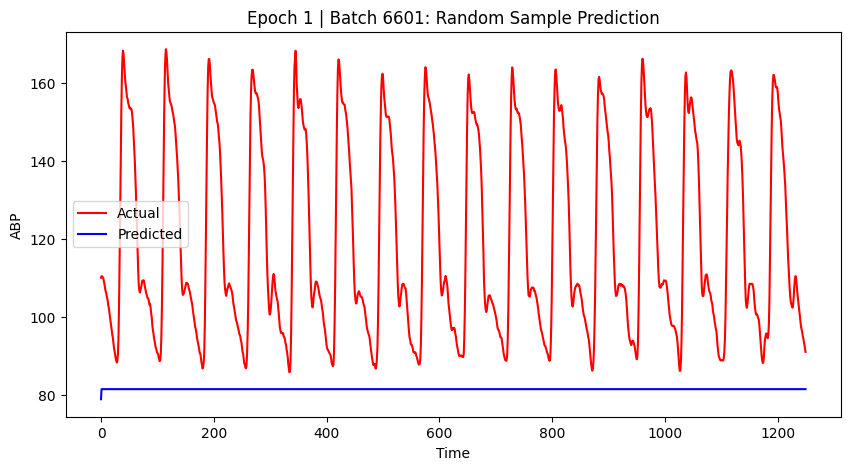

430.46734619140625


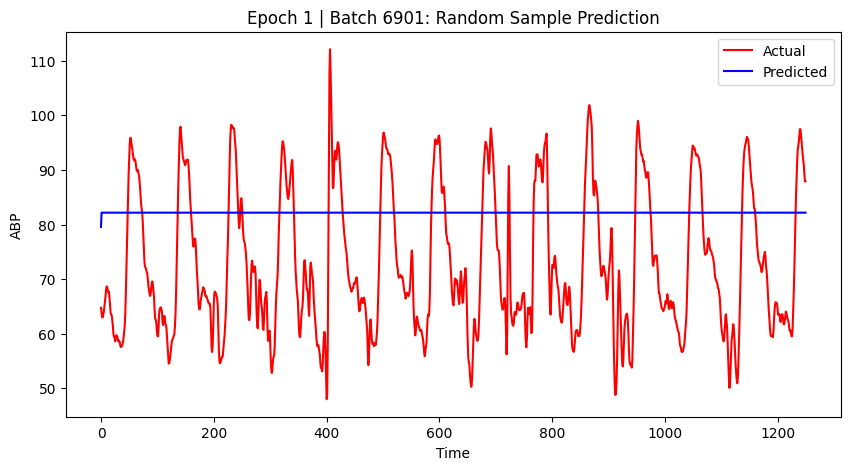

707.9523315429688


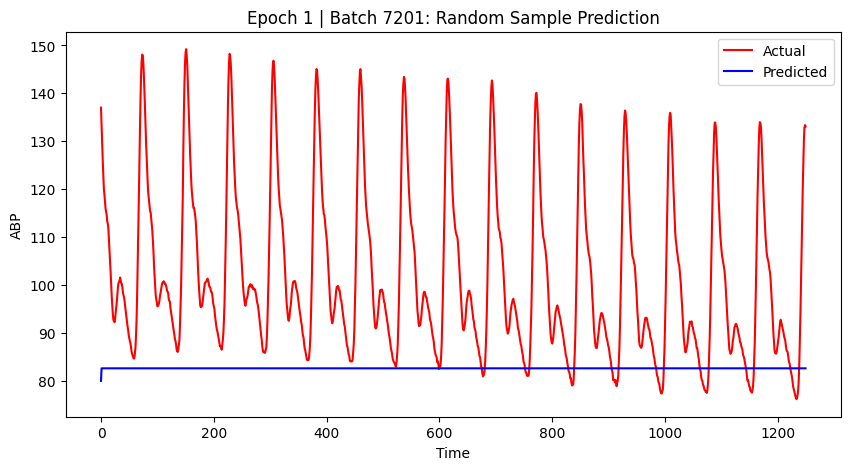

599.0635986328125


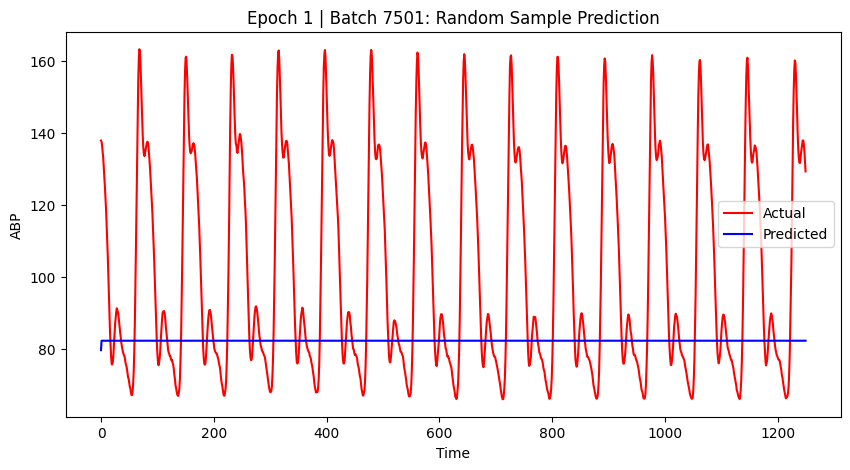

647.6785888671875


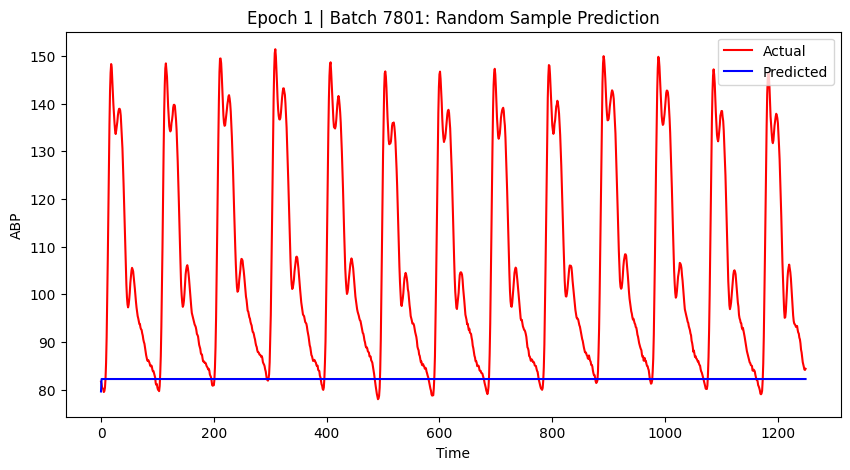

463.060302734375


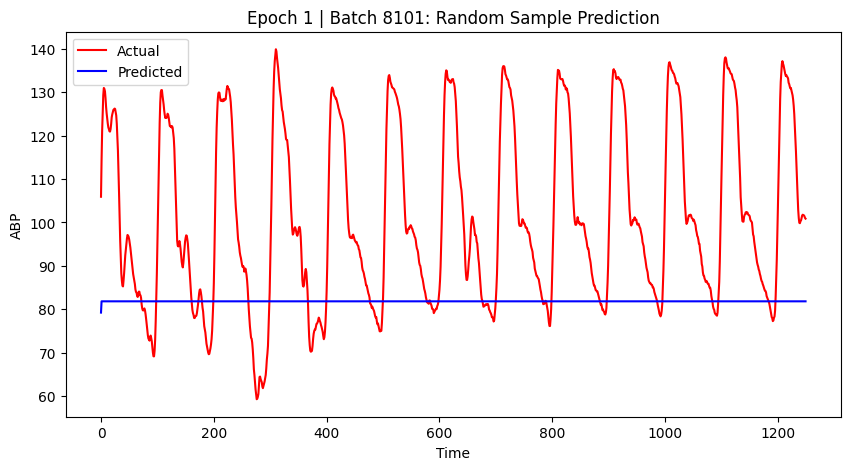

559.1847534179688


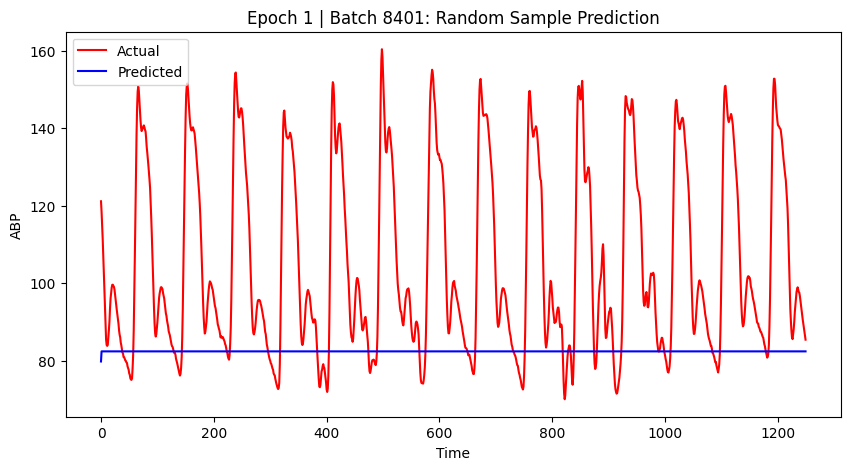

409.9105529785156


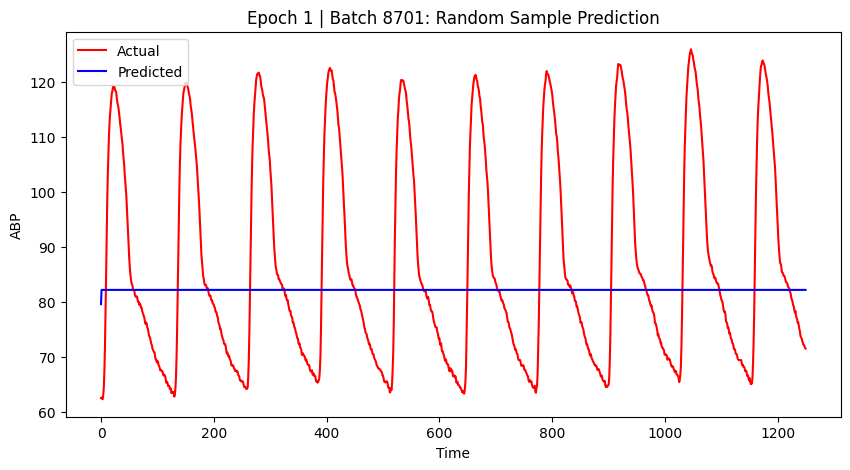

455.5489196777344


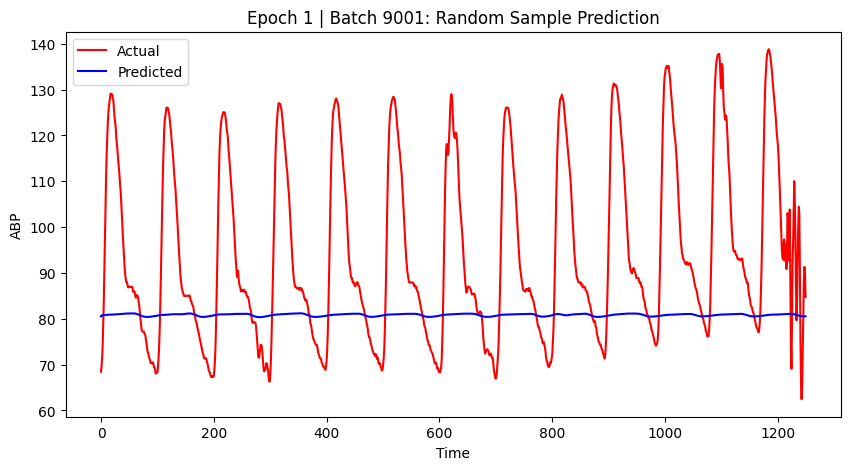

702.2612915039062


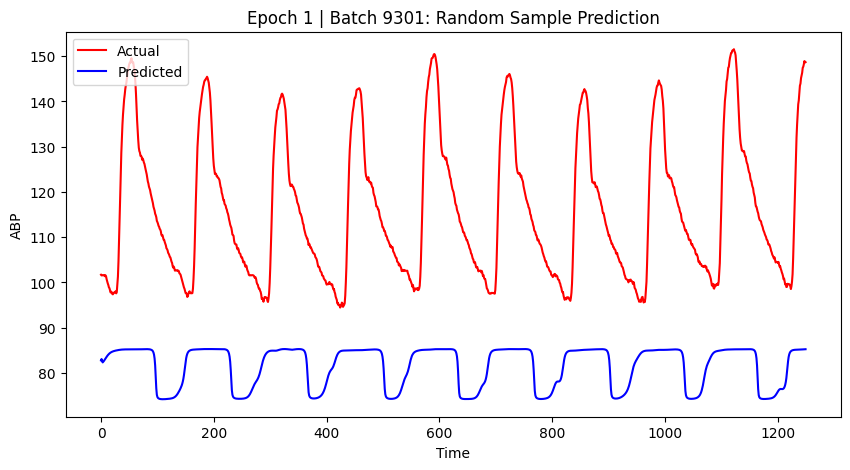

637.0344848632812


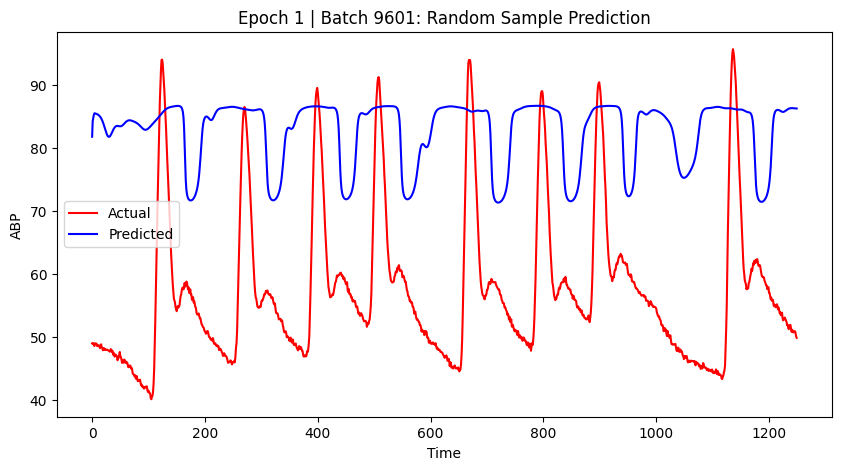

408.49072265625


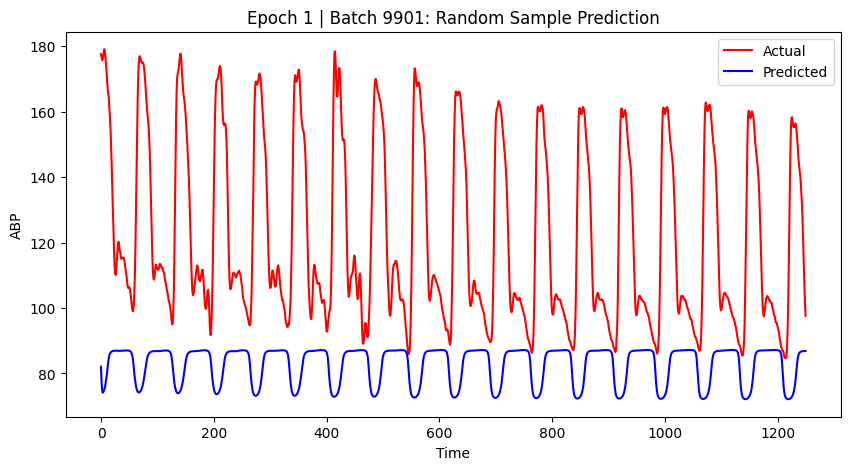

589.84814453125


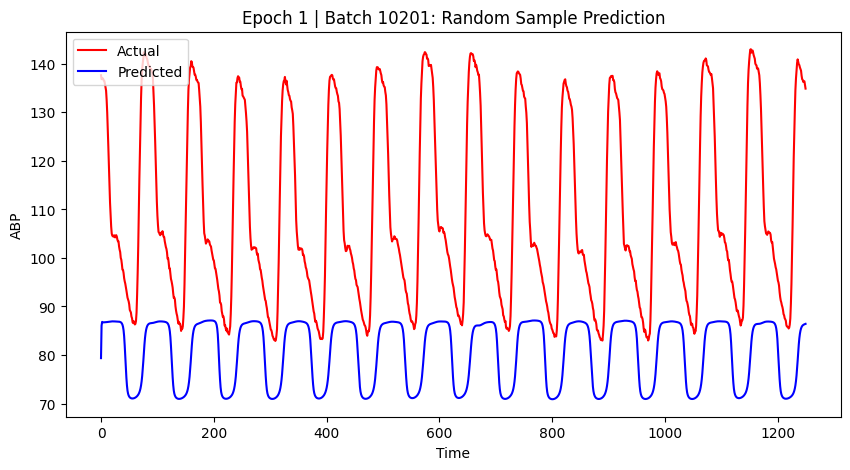

449.16021728515625


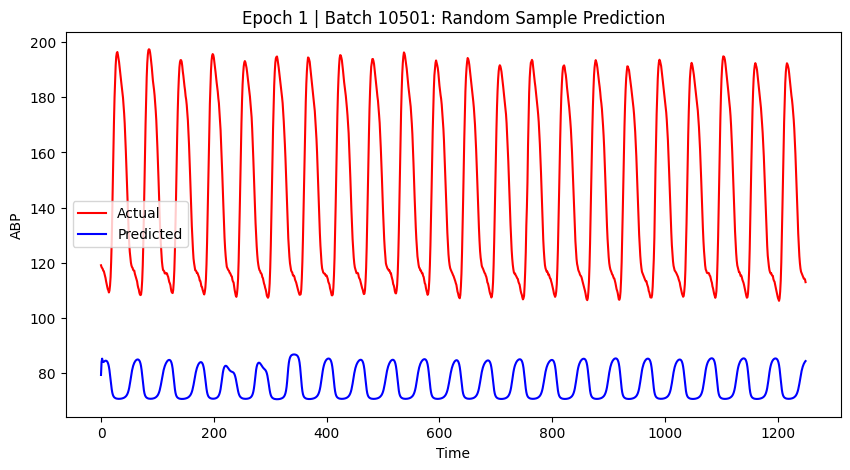

393.3240661621094


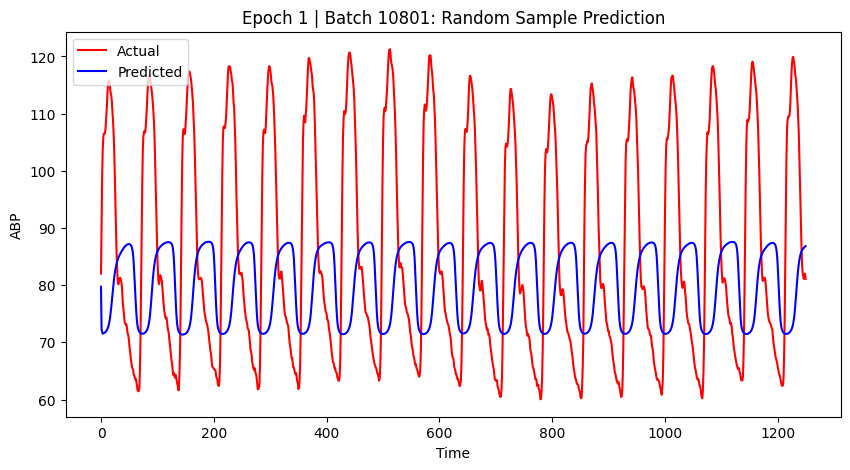

547.1712646484375


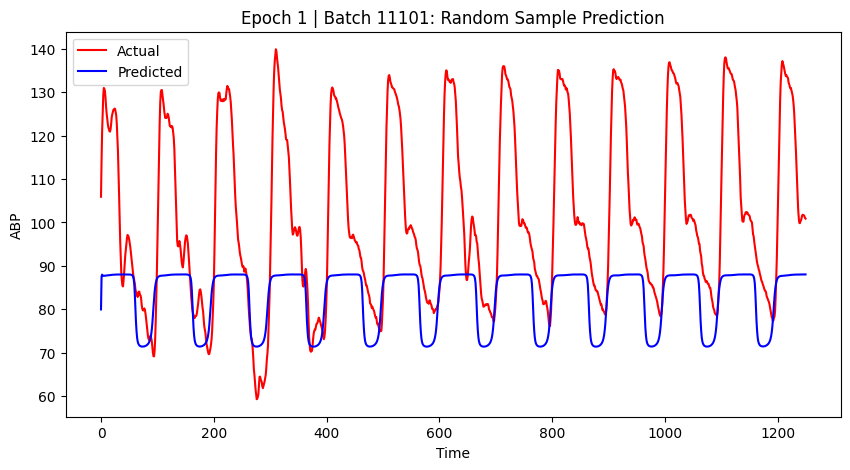

435.14434814453125


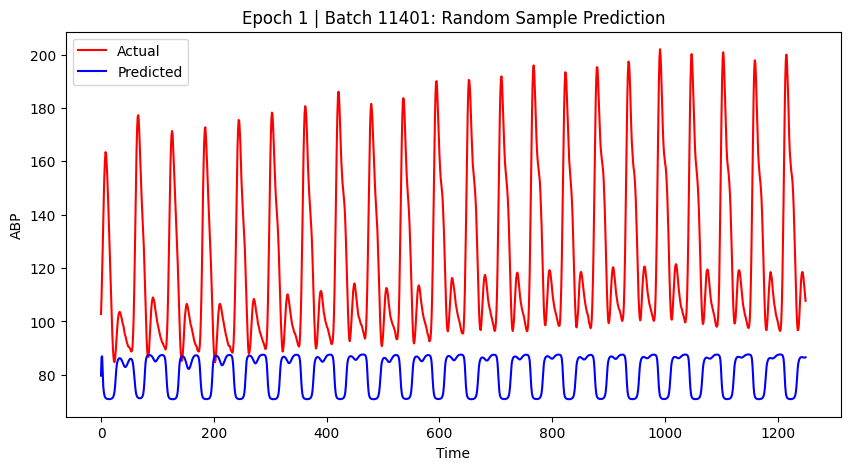

549.9125366210938


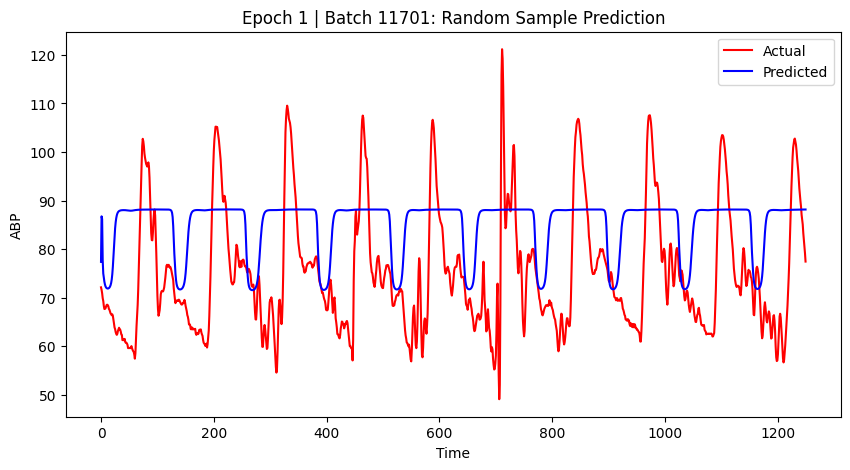

468.8359375


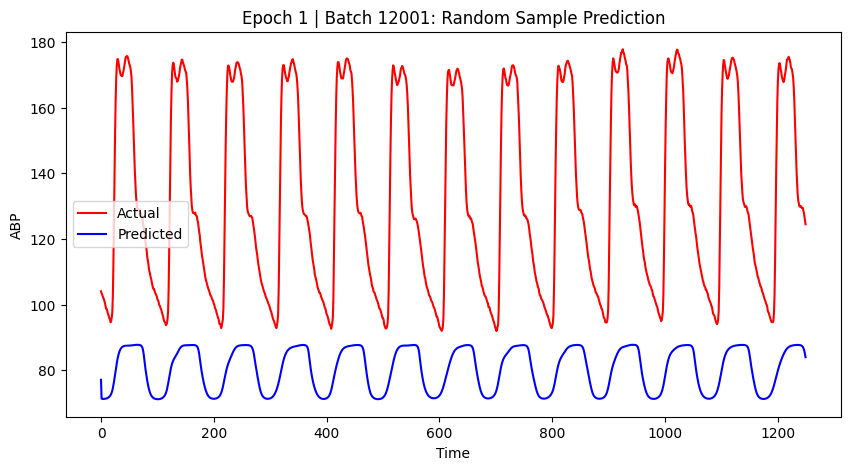

553.0693969726562


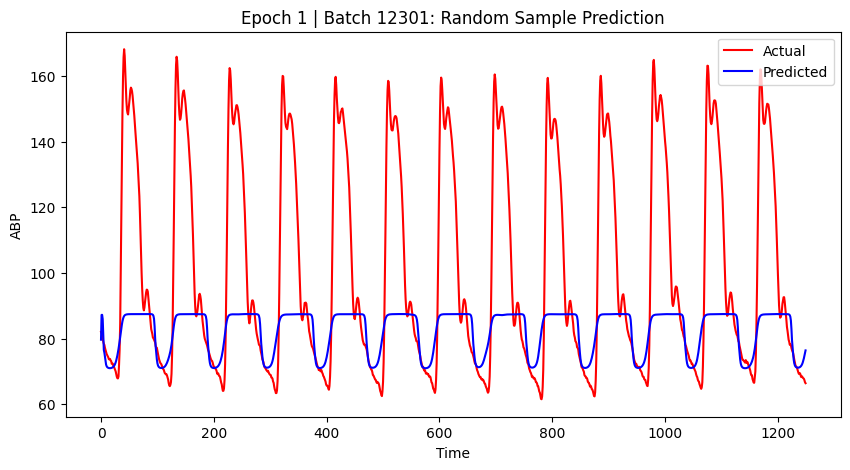

371.111328125


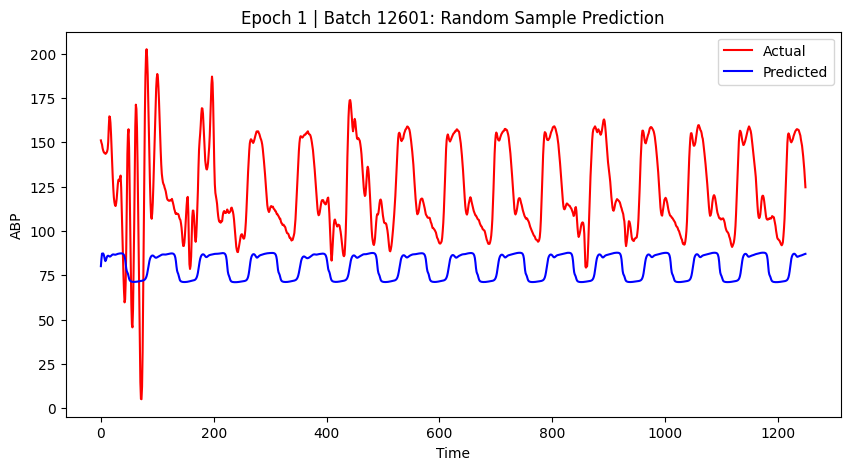

410.9390563964844


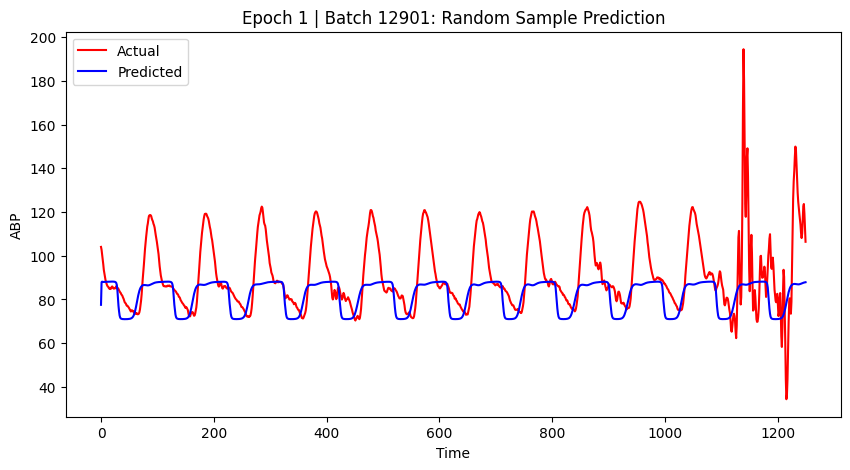

457.947998046875


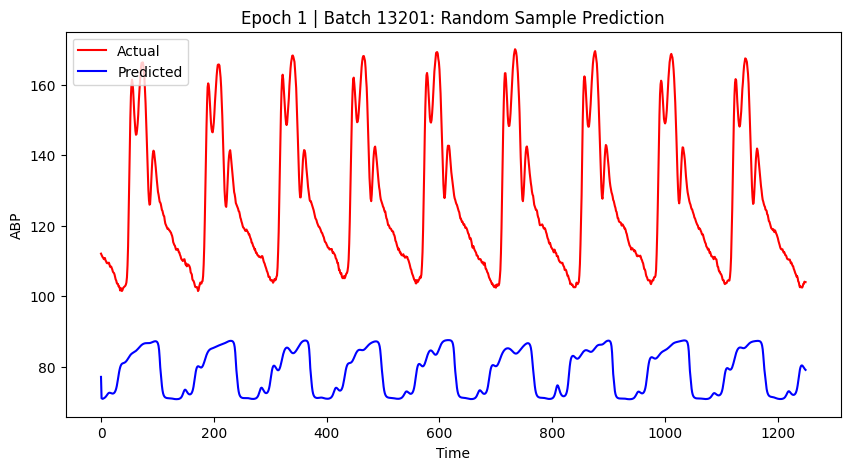

321.45770263671875


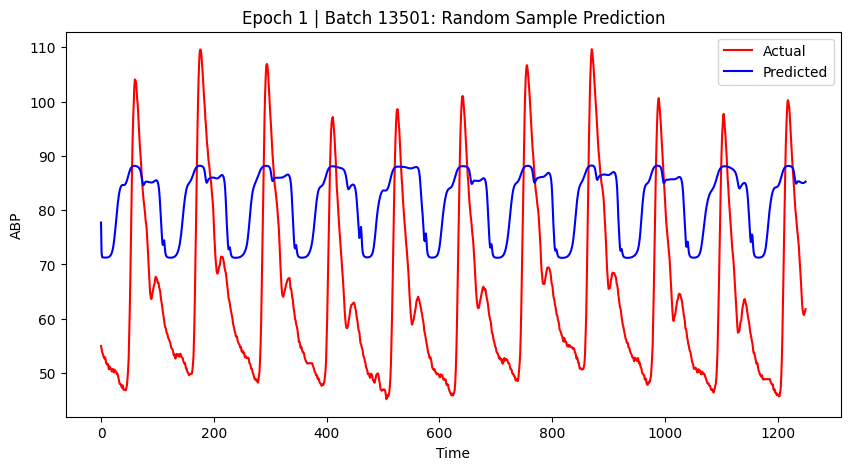

421.6691589355469


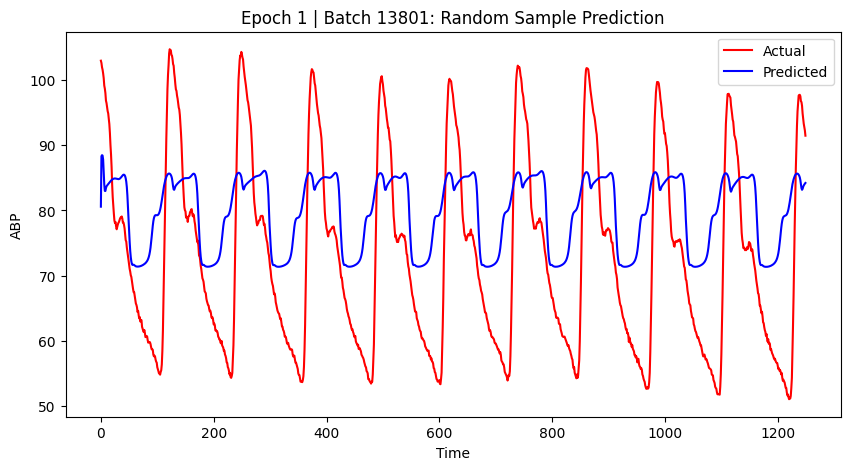

379.06854248046875


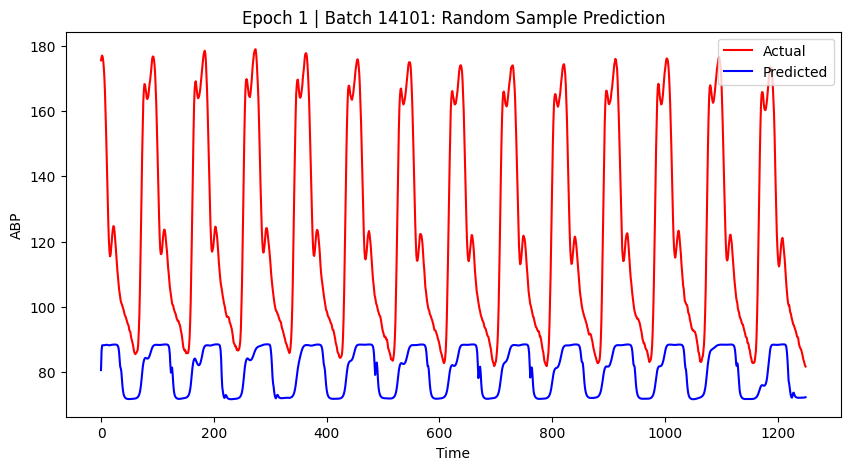

376.9742431640625


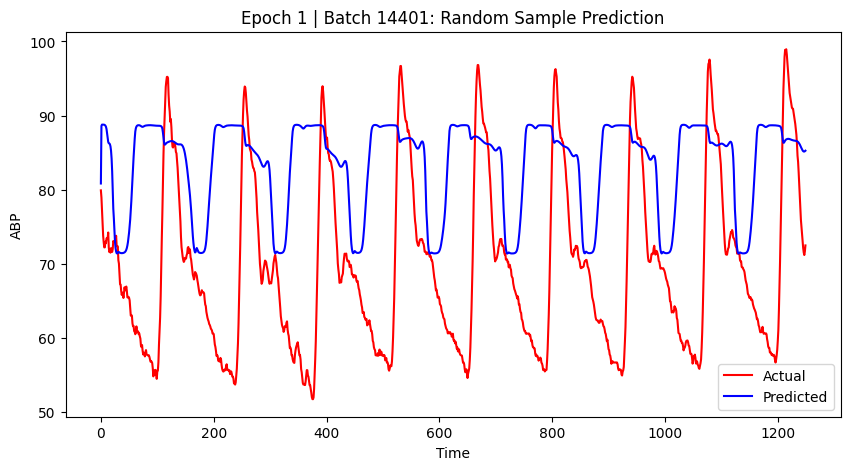

494.0444030761719


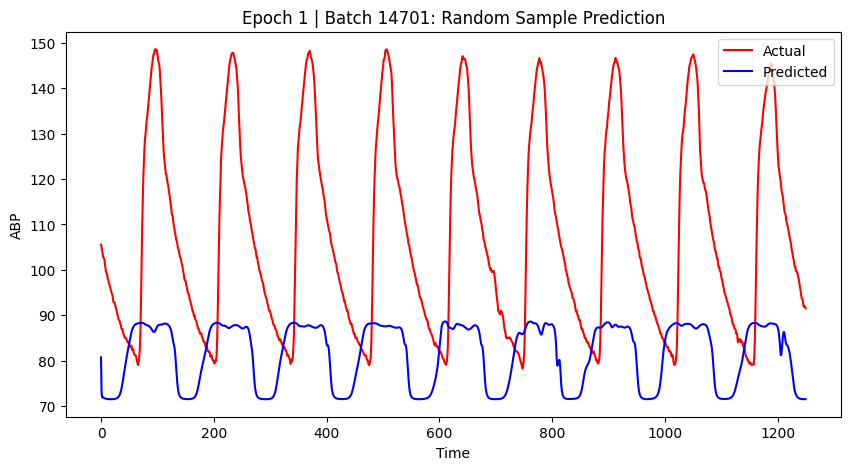

304.91400146484375


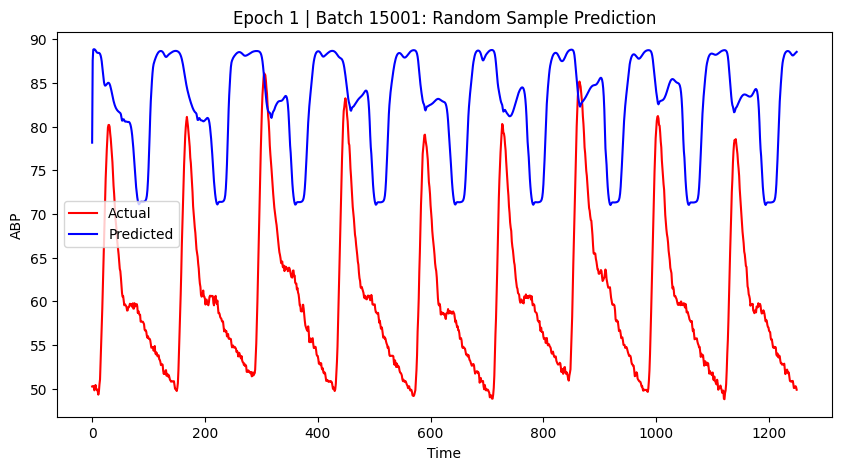

525.3203735351562


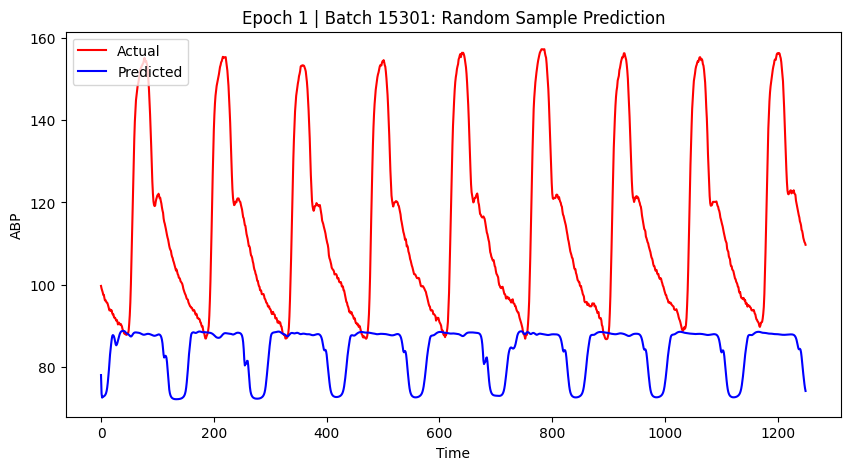

557.5873413085938


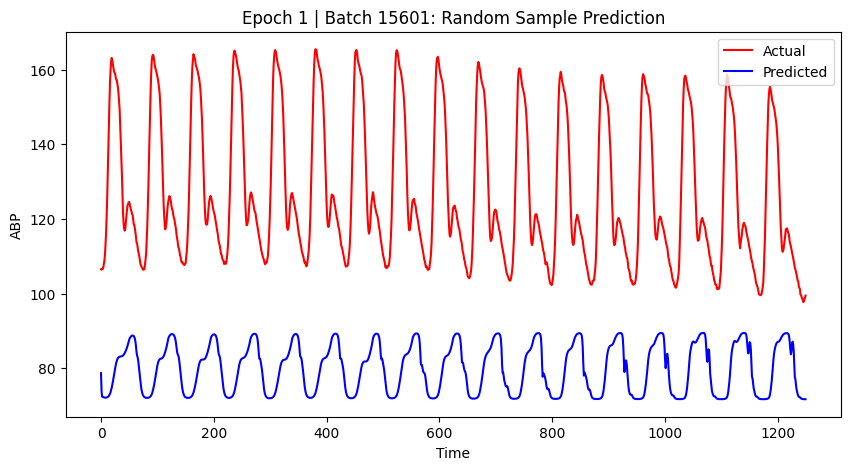

451.7353515625


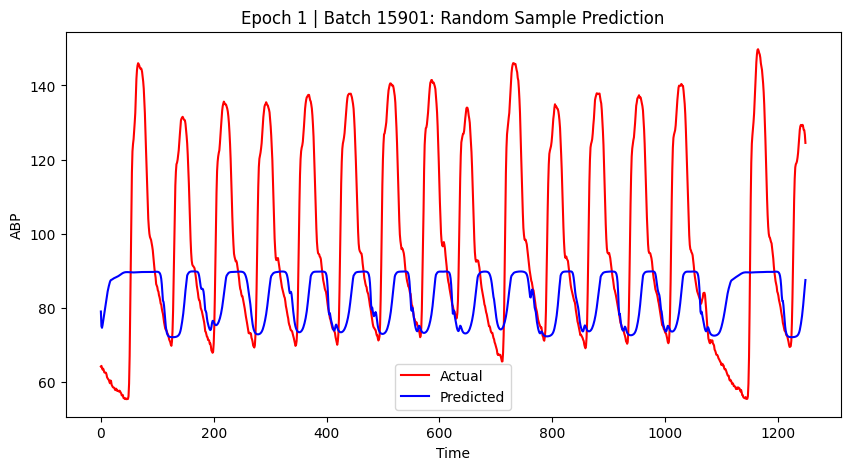

832.3394165039062


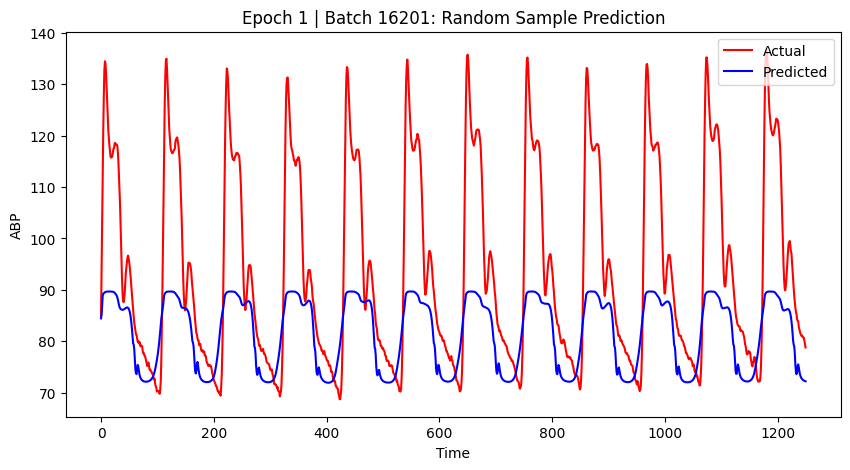

KeyboardInterrupt: 

In [81]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        time_series_data = data[:, :1250].unsqueeze(2).to(device)  # Shape: [batch, 1250, 1]
        additional_features = data[:, 1250:].to(device)  # Shape: [batch, 5]
        target = target.to(device)
        
        optimizer.zero_grad()
        output = model(time_series_data, additional_features)
        loss = criterion(output.squeeze(), target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        if batch_idx%300 == 0:
            print(loss.item())
            plot_random_sample(model, X_test, Y_test, device, epoch, batch_idx)
            

    # Validation
    model.eval() 
    val_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            time_series_data = data[:, :1250].unsqueeze(2).to(device)
            additional_features = data[:, 1250:].to(device)
            target = target.to(device)
            output = model(time_series_data, additional_features)
            val_loss += criterion(output.squeeze(), target).item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}')

print("Training completed.")